# Signal convolutions

To convolute two signals, we define a wrapper over torch.nn.functional.conv1d with the following constraints:

1. I treat one signal X as input signal and the other signal Y as the time-invarint impulse response (IR) of a system;

2. I assume output Z has the same length as input signal X

3. For input signals in shape (batch, length, dim), the output signals is also in shape (batch, length, dim), and the system IR is (length_2, dim)

4. convolution is conducted for each dimension in each batch separately.

In [4]:
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func
import sys

class SignalsConv1d(torch_nn.Module):
    """ Filtering input signal with time invariant filter
    
    Define: 
        SignalsConv1d()
    See usage in forward() method
    """                                                                   
    def __init__(self):
        super(SignalsConv1d, self).__init__()
        
    def forward(self, signal, system_ir):
        """ output = forward(signal, system_ir)
        
        signal:    (batchsize, length1, dim)
        system_ir: (length2, dim) 
        
        output:    (batchsize, length1, dim)
        
        Note: 
        """ 
        if signal.shape[-1] != system_ir.shape[-1]:
            print("Error: TimeInvariantFiltering expects shape:")
            print("signal    (batchsize, length1, dim)")
            print("system_id (batchsize, length2, dim)")
            sys.exit(1)
            
        # similar opration to Conv1dInvFilter
        # padding length
        padding_length = system_ir.shape[0] - 1
        
        # groups = signal.shape[-1] so that convoluion is separately 
        #  for each dimension
        groups = signal.shape[-1]
        
        # 1. siwtch dimension of the signal from (batch, length, dim) to (batch, dim, length)
        # 2. pad signal on the left to (batch, dim, length + pad_length)
        signal_pad = torch_nn_func.pad(signal.permute(0, 2, 1),\
                                       (padding_length, 0))
        
        # 1. add one dimension to system_ir and makes its shape (length2, 1, dim)
        # 2. switch dimension and prepare system_id as (dim, 1, length2)
        # 3. flip the impulse response 
        ir = torch.flip(system_ir.unsqueeze(1).permute(2, 1, 0), \
                        dims=[2])
        
        # convolute
        output = torch_nn_func.conv1d(signal_pad, ir, \
                                      groups=groups)
        # switch dimension from (batch, dim, length) to (batch, length, dim)
        return output.permute(0, 2, 1)

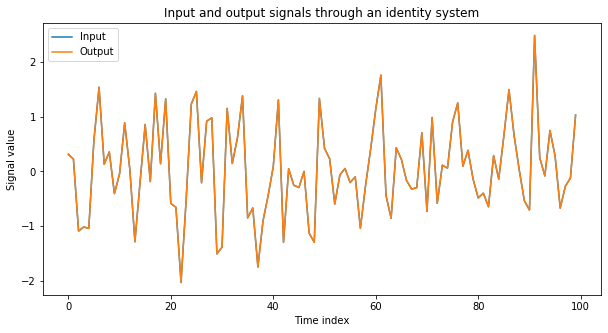

In [13]:
from scipy import signal as sci_signal
import scipy.fft
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 5)


# Example 1
# input -> An identity system H(z) = 1 -> output

# input signal
signal_input = torch.randn(2, 100, 2)
# impulse response of an identiy sytem [1, 0]
system_ir = torch.ones(2, 2)
system_ir[1:, :] = 0

# do filtering
filter_layer = SignalsConv1d()
signal_output = filter_layer(signal_input, system_ir)

plt.figure()
plt.plot(signal_input[0, :, 1])
plt.plot(signal_output[0, :, 1])
plt.xlabel('Time index')
plt.ylabel('Signal value')
plt.legend(['Input', 'Output'])
plt.title('Input and output signals through an identity system');


([<matplotlib.axis.XTick at 0x7f8258d1e460>,
 <a list of 3 Text xticklabel objects>)

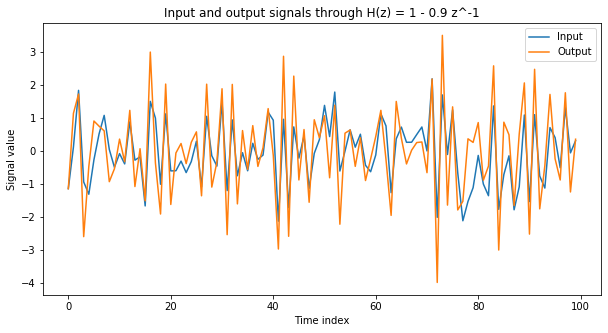

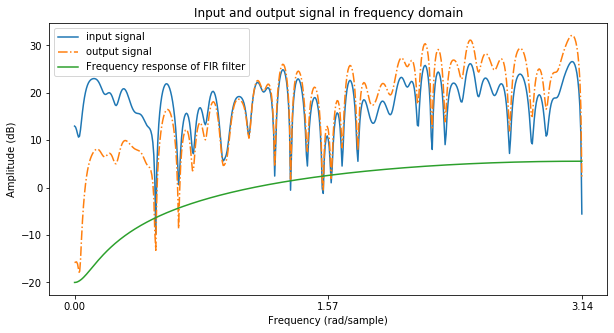

In [20]:
# Example 2
# input -> Linear Time-invarint system H(z) = 1 - 0.9 z^-1  -> output

# input signal
signal_input = torch.randn(2, 100, 2)
# impulse response of an identiy sytem [1, -0.9]
system_ir = torch.ones(2, 2)
system_ir[1:, :] = -0.9

# do filtering
filter_layer = SignalsConv1d()
signal_output = filter_layer(signal_input, system_ir)

# plot in time domain
plt.figure()
plt.plot(signal_input[0, :, 0])
plt.plot(signal_output[0, :, 0])
plt.xlabel('Time index')
plt.ylabel('Signal value')
plt.legend(['Input', 'Output'])
plt.title('Input and output signals through H(z) = 1 - 0.9 z^-1')

# plot in frequency domain
nfft = 1024
plt.figure()
h = scipy.fft.fft(signal_input[0, :, 0].detach().numpy(), n=nfft)
plt.plot(20*np.log10(np.abs(h[0:nfft//2+1]) + np.finfo(np.float32).eps))

h = scipy.fft.fft(signal_output[0, :, 0].detach().numpy(), n=nfft)
plt.plot(20*np.log10(np.abs(h[0:nfft//2+1]) + np.finfo(np.float32).eps), '-.')

w, h = scipy.signal.freqz(system_ir[:, 0], [1], worN=nfft, whole=True)
plt.plot(20*np.log10(np.abs(h[0:nfft//2+1]) + np.finfo(np.float32).eps))
plt.legend(['input signal', 'output signal', 'Frequency response of FIR filter'])
plt.title('Input and output signal in frequency domain')
plt.xlabel('Frequency (rad/sample)')
plt.ylabel('Amplitude (dB)')
plt.xticks([0, nfft // 4, nfft // 2], ['%1.2f' % (x * 2 * np.pi) for x in [0, 0.25, 0.5]])